# 案例介绍：

图像语义分割是一门涉及计算机视觉、模式识别与人工智能等研究领域的交叉学科，是计算机视觉中重要的基本问题之一。其目标是对图像的每个像素点进行分类，将图像分割为若干个视觉上有意义的或感兴趣的区域，以利于后续的图像分析和视觉理解。

近年来，深度卷积神经网络的出现，极大地推动了语义分割的发展。如今语义分割在虚拟现实、工业自动化、视频检测等不同领域有广泛的应用。本案例介绍了如何使用FCN算法进行语义分割，并与U-Net算法的分割效果进行对比。

# 目录
[1. 数据集简介](#1)<br>
[2. FCN模型介绍](#2)<br>
[3. 数据预处理](#3)<br>
[4. 模型构建](#4)<br>
[5. 模型训练](#5)<br>
[6. 语义分割效果](#6)<br>
[7. U-Net模型介绍](#7)<br>
[8. 模型效果对比](#8)<br>
[9. 总结](#9)<br>




<div id="1"></div>
# 1 数据集简介

VOC2012数据集常用于图像分割、分类等领域，数据集中共标注出20类物体，包括背景则为21类，物体分别如下： 
人、动物类（鸟、猫、牛、狗、马、羊）、车辆类（飞机、自行车、船、公交车、汽车、摩托车、火车）、室内场景（水壶、椅子、餐桌、盆栽、沙发、电视机）。

【图像分类.jpg】


数据集大小为316MB，`JPEGImages`文件夹下包含3000张以上原图，`SegmentationClass`文件夹下包含真实分割图像，与原图的图像名一一对应。每张图像的大小都不相同。分割图像中每个物体的轮廓用不同的颜色填充。如下图中，左图为原始图像，右图对应其分割结果。其中不同的摩托车被标注为不同的颜色。


【VOC分割.png】


<div id="2"></div>
# 2 FCN模型介绍

卷积神经网络对图像的语义分割效果很好，本文介绍FCN模型。这一模型建立“全卷积”网络，能够接受任意大小的输入。同时，FCN模型利用反卷积（上采样），能够还原特征映射，产生相应大小的输出，进行精确预测。并且采用跳跃结构，将来自深层、粗糙的语义信息与来自浅层、细致的外观信息结合起来，应用到多层信息，使预测更精确。

下图为FCN模型的网络结构。其中FCN-32s层表示，上采样步长为32，将预测大小恢复为原图像大小，但这会导致损失信息过多，结果不够精细。为了解决此问题，作者引入了跳级连接的策略。即FCN-16s：先进行上采样，再和第4层池化层（pool4）的预测结果相结合。最终进行上采样，恢复为原图大小。FCN-8s的作用同理，即先上采样，再结合高层信息，最后上采样为原图大小。

这样的网络结构，能够更好地预测分割细节，获得更高的精度。


【FCN模型.jpg】



<div id="3"></div>
# 3 数据预处理

首先读取VOC2012数据，解压`zip`格式的数据集，以便观察数据集中的内容。

In [ ]:
!apt install unzip
!unzip voc2012.zip

加载所需要的库，方便后续进行调用。

In [2]:
import os
import random
from torchvision.transforms import transforms as tfs
import sys
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import cv2
from torch.utils.data import DataLoader
import torch
import  matplotlib.pyplot as plt
import  torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import time
import torch.nn.functional as F

`train.txt`、`val.txt`文件中分别包含我们选择的训练集和验证集的图像名称。我们定义函数，通过该文件，读取训练集、测试集的图像。

In [3]:
# 读取图像的路径
voc_root="/content/voc2012"

def read_images(root=voc_root,train=True):
    # train == True，加载训练集数据；False则加载验证集数据
    txt_filename=root+"/ImageSets/Segmentation/"+('train.txt'if train else 'val.txt')
    # 读取图像名称
    with open(txt_filename,'r') as f:
        images=f.read().split()
    # 原始图像读取路径
    data=[os.path.join(root,'JPEGImages',i+'.jpg')for i in images]
    # 分割图像读取路径
    label=[os.path.join(root,'SegmentationClass',i+'.png')for i in images]
    return data,label

`train_data`、`train_label`中储存了训练集所需要的原图和分割图像的读取路径，如下所示。

In [4]:
train_data,train_label = read_images()
print("训练集原始图像路径： ",train_data[0:5])
print("训练集分割图像路径： ",train_label[0:5])

训练集原始图像路径：  ['/content/voc2012/JPEGImages/2007_000032.jpg', '/content/voc2012/JPEGImages/2007_000039.jpg', '/content/voc2012/JPEGImages/2007_000063.jpg', '/content/voc2012/JPEGImages/2007_000068.jpg', '/content/voc2012/JPEGImages/2007_000121.jpg']
训练集分割图像路径：  ['/content/voc2012/SegmentationClass/2007_000032.png', '/content/voc2012/SegmentationClass/2007_000039.png', '/content/voc2012/SegmentationClass/2007_000063.png', '/content/voc2012/SegmentationClass/2007_000068.png', '/content/voc2012/SegmentationClass/2007_000121.png']


我们随机抽取出一张图片，并展示其对应的分割图像。下图中，白色代表物体边框，黑色表示背景，其他不同的颜色对应着不同物体，如图中两辆火车标注为不同的颜色。

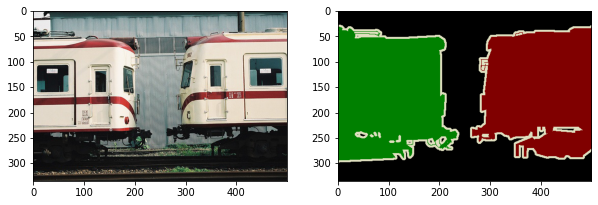

In [ ]:
# 展示原始图像和分割图像
x = np.array(Image.open('/content/voc2012/JPEGImages/2007_000042.jpg').convert("RGB"))
y = np.array(Image.open('/content/voc2012/SegmentationClass/2007_000042.png').convert("RGB"))
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(x)
plt.subplot(122)
plt.imshow(y)
plt.show()

将多张图片合并成一个批次，可以加速计算，但这要求输入图像大小一致。考虑到原图大小并不相同，我们需要对其进行处理。

在语义分割应用中，对图像进行放缩的方法并不合适，因为对原图进行放缩的同时，也需要对分割图像进行相应的放缩。但在调整分割图像大小的时候，会改变像素的颜色，使像素颜色对应物体类别变得困难。

我们可以采用“剪切”的方法，解决这一问题。具体而言，对于输入的图像，随机剪切得到一个固定大小的区域，同时，也对分割图像在同样位置进行剪切。这样操作可以保证原图和分割图像的一致性，且不会影响像素颜色代表的物体类别。

In [5]:
# 剪切函数
def rand_crop(data,label,height,width):
    h,w,_=data.shape
    top=random.randint(0,h-height)
    left=random.randint(0,w-width)
    data=data[top:top+height,left:left+width]
    label=label[top:top+height,left:left+width]
    return data,label

调用剪切图像的函数`rand_crop`，从下图可以看到，我们随机剪切了图像的一部分，包含了两辆火车的部分车身，分别用绿色和红色表示，图中黑色部分为背景。

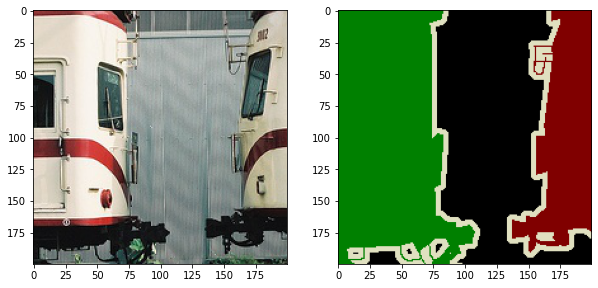

In [ ]:
# 剪切函数
r_x,r_y = rand_crop(x,y,200,200)
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(r_x)
plt.subplot(122)
plt.imshow(r_y)
plt.show()

接下来采用不同的颜色表示不同的物体，列出了每个物体和背景对应的RGB值，便于读取VOC2012数据集中的图像分割标注结果。但在分割结果中，为了更清楚地表示出不同物体，我们对于同一类别的不同个体，也采取了不同颜色。

In [6]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
           
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],

            [0,192,0],[128,192,0],[0,64,128]]
print("物体类别数量： ",len(classes))
print("对应颜色数量： ",len(colormap))

物体类别数量：  21
对应颜色数量：  21


通过定义RGB值和其对应的类别，给定一张图像分割结果，就可以找到每个像素对应的物体类别。定义像素值和物体类别的转换函数为`image2label`。

In [7]:
cm2lbl=np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]]=i

def image2label(im):
    data=np.array(im,dtype='int32')
    idx=(data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return np.array(cm2lbl[idx],dtype='int64')

现在我们将原始图像和其对应的分割图像，随机剪切到要求的形状，并将分割图像里每个像素转成对应的物体类别标号。考虑到有的图像过于小，不便于进行剪切，我们将小于要求大小的图片全部过滤。

In [8]:
def img_transforms(im,label,crop_size):
    # 剪切图像
    im,label=rand_crop(im,label,*crop_size)
    # 转换图像大小
    im_tfs=tfs.Compose([
        tfs.ToTensor(),
        tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    im=im_tfs(im)
    # 找到像素对应的物体类别
    label=image2label(label)
    label=torch.from_numpy(label)
    return im,label

In [9]:
class VOCSegDataset(Dataset):
    def __init__(self,train,crop_size,transforms):
        self.crop_size=crop_size
        self.transforms=transforms
        data_list,label_list=read_images(train=train)
        self.data_list=self._filter(data_list)
        self.label_list=self._filter(label_list)
        print('Read'+str(len(self.data_list))+'images')
    
    # 图像大小若小于剪切的尺寸，则删去不用
    def _filter(self,images):
        return [im for im in images if(Image.open(im).size[1] >= self.crop_size[0] and
                                      Image.open(im).size[0] >= self.crop_size[1])]
    
    # 读取转化后的图像
    def __getitem__(self,idx):
        img=self.data_list[idx]
        label=self.label_list[idx]
        img=cv2.imread(img)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label=cv2.imread(label)
        label=cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
        img,label=self.transforms(img,label,self.crop_size)
        return img,label
    
    def __len__(self):
        return len(self.data_list)

调用定义的函数，读取剪切后的图像，为训练模型做准备，可以看到训练集和验证集分别读取了1114张和1078张图像，并进行剪切，转化图像大小。我们采用$320\times 480$的图像大小用以训练。

In [10]:
input_shape=(320,480)
voc_train=VOCSegDataset(True,input_shape,img_transforms)
voc_test=VOCSegDataset(False,input_shape,img_transforms)

Read1114images
Read1078images


调用`DataLoader`函数，读取剪切并转换后的数据集，可以在训练模型时，分批次读取数据进行训练。

In [11]:
# 调用DataLoader函数读取数据
train_data=DataLoader(voc_train,batch_size=6,shuffle=True)
valid_data=DataLoader(voc_test,batch_size=6)

<div id="4"></div>
# 4 模型构建

读取数据后，便可以构建FCN模型，以进行训练。我们基于ResNet模型来创建FCN，首先下载预训练好的ResNet网络模型。


In [12]:
pretrained_net=models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


FCN网络不需要全连接层，且需要添加新的卷积层进行上采样。在训练的时候，我们需要初始化新添加的上采样卷积层。可以进行随机初始化，但实际中发现，将上采样卷积层初始化成双线性差值函数可以使训练更容易。下列为双线性插值函数`bilinear_kernel`。

In [13]:
# 双线性差值函数
def bilinear_kernel(in_channels,out_channels,kernel_size):
    factor=(kernel_size+1)//2
    if kernel_size%2==1:
        center=factor-1
    else:
        center=factor-0.5
    og=np.ogrid[:kernel_size,:kernel_size]
    filt=(1-abs(og[0]-center)/factor)*(1-abs(og[1]-center)/factor)
    weight=np.zeros((in_channels,out_channels,kernel_size,kernel_size),dtype='float32')
    weight[range(in_channels),range(out_channels),:,:]=filt
    return torch.from_numpy(weight)

下面是FCN的网络结构。如前所述，FCN网络包含了上采样过程，以及跳跃结构。总体来看，FCN网络的构建包括三部分：由预训练的ResNet模型得到主体卷积网络，删去ResNet网络的全连接层，并采用双线性差值函数替换上采样卷积层。



In [14]:
num_classes=len(classes)
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) # 第一段
        self.stage2 = list(pretrained_net.children())[-4] # 第二段
        self.stage3 = list(pretrained_net.children())[-3] # 第三段
        
        # 卷积层
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)
        
        # 上采样层
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # 使用双线性 kernel
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel

    def forward(self, x):
        x = self.stage1(x)
        s1 = x # FCN-8s
        
        x = self.stage2(x)
        s2 = x # FCN-16s
        
        x = self.stage3(x)
        s3 = x # FCN-32s
        
        # 上采样
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3
        
        # 上采样
        s1 = self.scores3(s1)
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s2)
        return s

<div id="5"></div>
# 5 模型训练

现在我们已经划分好了数据集，定义了模型的网络结构，可以代入数据，进行训练。

In [15]:
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    # 返回各类别包含的像素点个数
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist

# 返回准确率
def label_accuracy_score(label_trues, label_preds, n_class):
    # 初始化个像素点代表的类别
    hist = np.zeros((n_class, n_class))
    # 找到各像素点的类别，即各类别的像素点个数
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    # 计算分割准确率
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

定义损失函数为NLL损失函数，优化参数的方法为随机梯度下降（SGD算法）。

In [16]:
# 选择损失函数
criterion = nn.NLLLoss2d()

# 定义模型
net=fcn(num_classes)

# 选择优化函数
optimizer = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:219: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "


接下来代入数据，进行训练。我们训练120个Epoch，以达到较好的分割效果。

In [22]:
Valid_Loss_list = []
Valid_Acc_list = [] 
for e in range(120):
    # 初始化损失值、准确率等数值
    train_loss = 0
    train_acc = 0
    train_acc_cls = 0
    train_mean_iu = 0
    train_fwavacc = 0
    prev_time = time.time()

    # 初始化模型
    net = net.train()
    net=net.cuda()

    # 训练数据
    for data in train_data:
        # 存放变量im, label
        im = Variable(data[0].cuda())
        label = Variable(data[1].cuda())
        
        # 前向传播
        out = net(im)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        loss = criterion(out, label)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.data
        
        # 计算准确率
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            train_acc += acc
            train_acc_cls += acc_cls
            train_mean_iu += mean_iu
            train_fwavacc += fwavacc

    # 在验证集上进行验证 
    net = net.eval()  # 固定参数
    eval_loss = 0
    eval_acc = 0
    eval_acc_cls = 0
    eval_mean_iu = 0
    eval_fwavacc = 0

    # 在验证集上验证模型分割准确率
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        label = Variable(data[1].cuda(), volatile=True)
        
        # 前项传播
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, label)
        eval_loss += loss.data
        
        # 计算分割结果，以及分割准确率
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            eval_acc += acc
            eval_acc_cls += acc_cls
            eval_mean_iu += mean_iu
            eval_fwavacc += fwavacc
        
    cur_time = time.time()

    # 每个epoch的训练结果和准确率
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(voc_train), train_mean_iu / len(voc_train),
        eval_loss / len(valid_data), eval_acc / len(voc_test), eval_mean_iu / len(voc_test)))
    
    # 保存每个epoch的损失和准确率
    Valid_Loss_list.append(eval_loss / len(valid_data))
    Valid_Acc_list.append(eval_acc / len(voc_test))
    
    if e%10 == 0:
      print(epoch_str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 0, Train Loss: 0.78841, Train Acc: 0.77491, Train Mean IU: 0.38931, Valid Loss: 0.59494, Valid Acc: 0.81355, Valid Mean IU: 0.46224 
Epoch: 10, Train Loss: 0.33646, Train Acc: 0.88896, Train Mean IU: 0.54683, Valid Loss: 0.52754, Valid Acc: 0.83714, Valid Mean IU: 0.46925 
Epoch: 20, Train Loss: 0.21024, Train Acc: 0.93040, Train Mean IU: 0.63522, Valid Loss: 0.61663, Valid Acc: 0.83737, Valid Mean IU: 0.46440 
Epoch: 30, Train Loss: 0.16228, Train Acc: 0.94484, Train Mean IU: 0.68423, Valid Loss: 0.69464, Valid Acc: 0.83696, Valid Mean IU: 0.45797 
Epoch: 40, Train Loss: 0.14159, Train Acc: 0.95065, Train Mean IU: 0.71103, Valid Loss: 0.70960, Valid Acc: 0.83835, Valid Mean IU: 0.45245 
Epoch: 50, Train Loss: 0.12759, Train Acc: 0.95477, Train Mean IU: 0.72732, Valid Loss: 0.71741, Valid Acc: 0.84274, Valid Mean IU: 0.46047 
Epoch: 60, Train Loss: 0.12091, Train Acc: 0.95653, Train Mean IU: 0.73811, Valid Loss: 0.74006, Valid Acc: 0.83860, Valid Mean IU: 0.45387 
Epoch: 70, Tra

<div id="6"></div>
# 6 语义分割效果

首先做图展示每个epoch中，模型在验证集上的准确率的变化。可以看到，随着训练次数增加，准确率逐步提升。




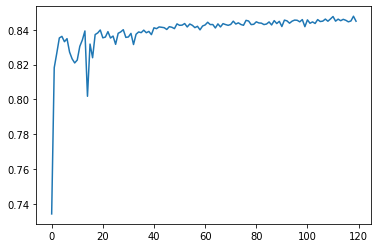

In [ ]:
plt.plot(Valid_Acc_list)
plt.show()

接下来，我们随机选取图片，展示模型的分割效果，并与真实分割图像进行对比。

In [ ]:
# 各类别的代表颜色
cm = np.array(colormap).astype('uint8')

In [ ]:
# 模型分割结果
def predict(im, label): 
    im = Variable(im.unsqueeze(0)).cuda()
    out = net(im)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]

下图中，左图为原始图像，中间图像为真实分割图像，右侧为FCN模型的分割结果。可以看到FCN模型的分割结果与真实分割图像基本一致，分割效果良好。

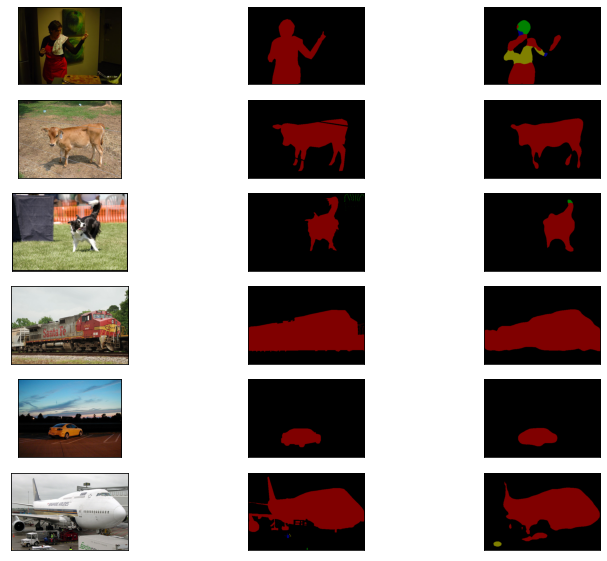

In [ ]:
# 在子图中画出原始图像、分割图像
_, figs = plt.subplots(6, 3, figsize=(12, 10))
m = random.sample(range(len(voc_test)), 6) 
for i in range(6):
    test_data, test_label = voc_test[m[i]]
    pred, label = predict(test_data, test_label)

    # 原始图像
    figs[i, 0].imshow(Image.open(voc_test.data_list[m[i]]))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)

    # 真实分割图像
    figs[i, 1].imshow(label)
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)

    # FCN分割结果
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)

<div id="7"></div>
# 7 U-Net模型介绍

在图像分割领域中，U-Net也是常用的方法。U-Net也称为对称语义分割模型，下图为其网络结构示意图。如图所示，U-Net主要由左半部分收缩路径，和右半部分对称的扩张路径组成。收缩路径采用卷积、RELU函数和最大池化，获得图像的上下文信息。对称扩张路径将获得的信息裁剪到与上采样的图像大小一致，再将它们连接起来，实现了不同层特征相结合的上采样特征图，可以精确定位分割边界。


【Unet.png】


<div id="8"></div>
# 8 模型效果对比

接下来加载已经训练好的U-Net模型，同样对VOC2012数据集进行图像分割，观察其分割效果。首先加载所需要的函数。

In [ ]:
!apt install unzip
!unzip UNet.zip

In [ ]:
cd UNet

In [ ]:
cp DataLoade.py ../

In [ ]:
cp Unet.py ../

In [ ]:
cp eval_tool.py ../

In [ ]:
import pandas as pd 
from DataLoade import CustomDataset
from Unet import UNet
import osgeo
from eval_tool import label_accuracy_score
import random 
from DataLoade import label2image,RandomCrop
from torch.utils.data import DataLoader

再加载训练好的模型参数，保存在`best_model_UNet.mdl`文件中，同时定义输入图像大小`INPUT_WIDTH`、`INPUT_HEIGHT`等参数数值。


In [ ]:
# 设置参数
GPU_ID = 0
INPUT_WIDTH = 320
INPUT_HEIGHT = 320
BATCH_SIZE = 32
NUM_CLASSES = 21
LEARNING_RATE = 1e-3
model_path='/content/UNet/best_model_UNet.mdl'

加载模型，并读取训练结果，得到可以进行图像分割的U-Net模型。

In [ ]:
# 加载模型
torch.cuda.set_device(GPU_ID)
net = UNet(3,NUM_CLASSES)
net = net.cuda()
net.load_state_dict(torch.load(model_path,map_location='cuda:0'))

<All keys matched successfully>

我们选取部分VOC2012数据集中的图像作为测试集，代入U-Net模型进行图像分割，观察分割结果。

In [ ]:
# 读取测试集
test_csv_dir = '/content/UNet/test.csv'
testset = CustomDataset(test_csv_dir,INPUT_WIDTH,INPUT_HEIGHT)
test_dataloader = DataLoader(testset,batch_size = 15,shuffle=False)

由输出结果，我们可以观察到U-Net可以大致识别出图像中的物体，并将其用不同颜色标识出来，但是准确率仍然需要提升。和FCN算法的结果相比较而言，二者都可以大致检测并标识出物体，但边缘部分的检测精度仍需要提升。可以考虑增加训练次数，或优化网络结构。

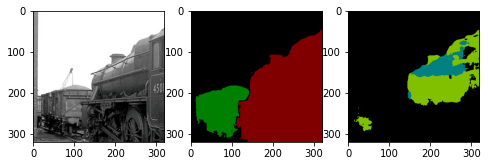

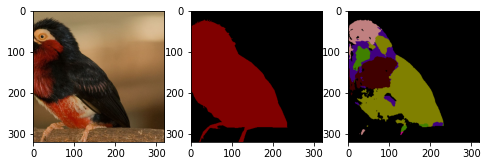

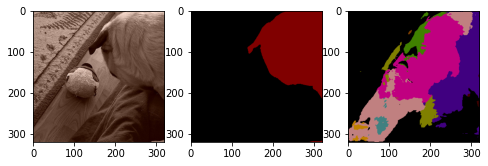

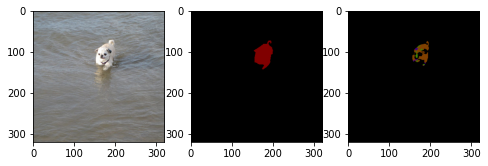

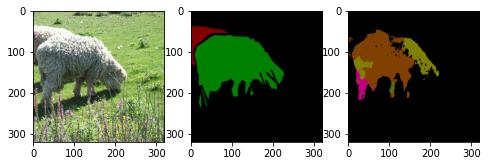

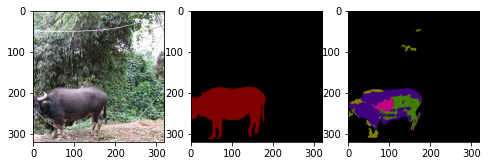

In [ ]:
# 图像分割
for (val_image,val_label) in test_dataloader:
    # 读取数据
    net.cuda()
    out = net(val_image.cuda())  
    pred = out.argmax(dim=1).squeeze().data.cpu().numpy() 
    label = val_label.data.numpy()
    val_pred, val_label = label2image(NUM_CLASSES)(pred, label)

    # 进行图像分割，并与真实分割结果对比
    for i in range(6):
        val_imag = val_image[i]

        # U-Net模型分割结果
        val_pre = val_pred[i]

        # 真实图像分割结果
        val_labe = val_label[i]
        
        # 反归一化，输出图像
        mean = [.485, .456, .406]
        std = [.229, .224, .225]
        x = val_imag
        for j in range(3):
            x[j]=x[j].mul(std[j])+mean[j]
        
        # 原始图像
        img = x.mul(255).byte()
        img = img.numpy().transpose((1, 2, 0)) 

        # 输出图像
        fig, ax = plt.subplots(1, 3,figsize=(8,8))
        ax[0].imshow(img)
        ax[1].imshow(val_labe)
        ax[2].imshow(val_pre)
    
    break # 只显示一个batch的部分分割结果

<div id="9"></div>
# 9 总结

语义分割在生活中的使用越加广泛，本案例介绍了如何使用FCN模型，对图像进行语义分割。并与U-Net模型的语义分割效果进行对比。选择VOC2012数据集进行训练，展示模型的分割结果，可以观察到模型的效果较好，能够准确识别图像中不同类别的物体，并且用不同的颜色表现出物体。但是模型分割的准确度仍然需要提升，识别物体边缘部分的能力需要优化。可以考虑继续训练U-Net及FCN模型，以得到更好的参数。或者优化二者的网络结构，提升网络性能。
